In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

# load custom libraries
from generate_mission_profile import pnt2line, vector, path_segment

# Developing the Mission Profile
We want a vector field for the uuv to travel in straight lines between waypoints.

The entire path will be generated at once.

A seperate vector field will be calculated for each waypoint.

## Geometry Setup
Global origin is in the bottom left corner (no negative coordinates).

In [2]:
# define the world grid
x_spacing = 1
y_spacing = 1
max_x = 20
max_y = 20

world_x = np.linspace(1,max_x,max_x*x_spacing)
world_y = np.linspace(1,max_y,max_y*y_spacing)
world_X, world_Y = np.meshgrid(world_x, world_y)

world_z=[0]


Calculate the vector points based on the closest line point

In [3]:
start_point = (3,3,0)
end_point = (18,18,0)

x_vec_array, y_vec_array = path_segment(start_point, end_point, world_x, world_y)

In [4]:
mission_dx = np.ones(world_X.shape)
mission_dy = np.ones(world_Y.shape)
mission_dz = np.zeros(world_X.shape)  # no movement in z dimension

behavior_dx = mission_dx + x_vec_array
behavior_dy = mission_dy + y_vec_array
behavior_dz = np.zeros(behavior_dx.shape)  # no movement in z dimension

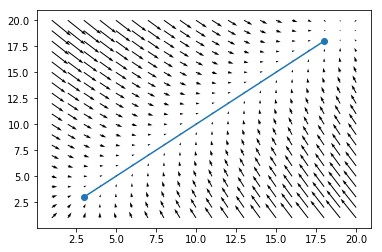

In [5]:
fig, ax = plt.subplots()
ax.quiver(world_X, world_Y, behavior_dx, behavior_dy)
ax.scatter([start_point[0], end_point[0]],[start_point[1],end_point[1]])
ax.plot([start_point[0], end_point[0]],[start_point[1],end_point[1]])
plt.show()

Output to a csv.
* Segment number
* x
* y
* z
* dx
* dy
* dz

In [6]:
# create pandas dataframe out of the reshaped arrays to feed into NetLogo
patch_data = pd.concat([pd.DataFrame(np.reshape(world_X,(world_X.size,1))), pd.DataFrame(np.reshape(world_Y,(world_Y.size,1))),pd.DataFrame(np.reshape(behavior_dx,(behavior_dx.size,1))), pd.DataFrame(np.reshape(behavior_dy,(behavior_dy.size,1)))], axis=1)

In [7]:
# write to datafile formatted for NetLogo
patch_data.to_csv('nav_field_diagonal_run.txt', index=False, header=False, sep=' ')